In [1]:
#IMPORT LIBRARIES
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Sequence, Dict
from functools import reduce
import sympy as sp

In [2]:
#CREATE A LINE AND A NOISE FOR IT
noise_std = 0.1
x = np.linspace(-2, 2, 100)
m = 1.
b = 0.
y = m * x + b + np.random.normal(0., noise_std, 100)

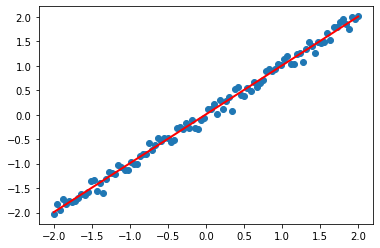

In [3]:
#FIT A LINE TO THE NOISY DATA AND PLOT IT
A = np.hstack((x[np.newaxis].T, np.ones((len(x), 1))))
b = y[np.newaxis].T
U, s, Vt = np.linalg.svd(A)
s_inv = np.array(s)

for i in range(len(s_inv)):
    if abs(s_inv[i] - 0.) > 1e-5:
        s_inv[i] = 1. / s_inv[i]
        
S_inv = np.zeros((Vt.shape[0], U.shape[1]))
np.fill_diagonal(S_inv, s_inv)
A_pinv = Vt.T.dot(S_inv).dot(U.T)
X = A_pinv.dot(b)
y_fit = X[0] * x + X[1]
plt.scatter(x,y)
plt.plot(x, y_fit, color='r', linewidth=2)
plt.show()

Equation:
\begin{equation}
F(v) = [Fc + (Fs - Fc)*e^{-|v/vs|^a}]*sgn(v) + \beta * v
\end{equation}

In [62]:
#FRICTION PARAMETERS
Fc = 1.5                      #unknown - Coulomb friction 
Fs = 3.0                      #known - Maximum static friction - constant
v = np.linspace(-3, 3, 100)   #known - Velocity of the motor - increases by our conviction
vs = 0.5                      #unknown - Stribeck velocity
a = 2                         #known - Most of references use 2
beta = 0.9                    #unknown - Sigma 2 - coefficient of viscous friction
sigma_0 = np.sqrt(10**5)      #unknown - Stiffness coefficient of bristles
#sigma_1 =                    #unknown - Damping coeffient
sigma_2 = beta

In [63]:
#CREATE A CURVE WITH NOISE
F = (Fc + (Fs - Fc) * np.exp(-abs(v/vs))**a)*np.sign(v) +beta*v
noise_std = 0.1
F_noisy = F + np.random.normal(0., noise_std, 100)

In [64]:
#FUNCTION TO PLOT MODELS
def show_model(y_fit, y, x):
    plt.figure(figsize=(8,8))
    plt.scatter(x,y_fit)
    plt.grid(color='b', linestyle='-', linewidth=0.1)
    plt.plot(x,y, color='r', linewidth=1)
    plt.xlabel('Velocity')
    plt.ylabel('Force')
    plt.show()

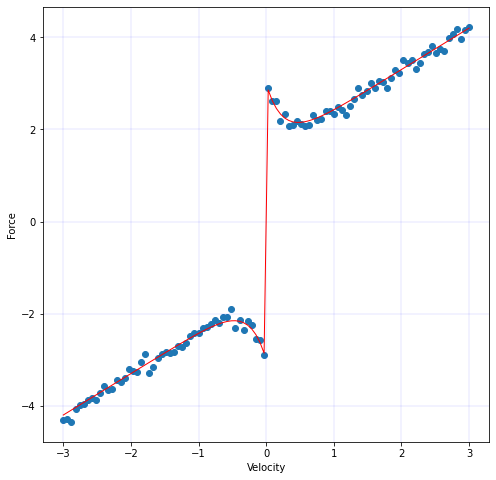

In [65]:
#PLOT THE CURVE AND THE NOISY DATA
show_model(F_noisy, F, v)

In [66]:
#FUNCTION TO DEFINE THE PARAMETERS AS SYMBOLS
def sol_symbolic_poly(poly_params: Sequence[sp.core.symbol.Symbol], Fs, v):
    return ((poly_params[0] + (Fs - poly_params[0]) * sp.exp(-(v/poly_params[1])**2))*np.sign(v) + poly_params[2]*v)

#FUNCTION TO CALCULATE THE ERROR OF THE ORIGINAL FUNCTION AND THE FUNCTION WITH NEW PARAMETERS
def error(poly_params, xs, ys, Fs):
    aux = ([0.])
    for i in range(len(xs)):
        aux.append(sol_symbolic_poly(poly_params, Fs, xs[i])-ys[i])
    return (reduce(lambda y, x: x**2 + y, aux))/(len(aux)-1)

In [67]:
#FUNCTION TO FIT THE PARAMETERS WITH THE ITERATIVE NEWTON METHOD
def newton(poly_params: Sequence[sp.core.symbol.Symbol], xs: np.ndarray, ys: np.ndarray, param_value_guess: np.ndarray,
    param_to_idx_map: Dict[str, int], Fs, max_iter: int=100, epsilon: float=0.01) -> Tuple[np.ndarray, int, float]:
    
    params = np.array(param_value_guess)
    params_final = np.array(param_value_guess)
    final_error = 1e10    
    eqns = []
    num_eqns = len(poly_params)
    num_data = len(xs)
    num_of_data_per_eqn = int(num_data/num_eqns)
    errorf = error(poly_params, xs, ys, Fs)
    X = sp.Matrix([errorf])
    Y = sp.Matrix(poly_params)
    myjac = X.jacobian(Y)
    #print(myjac)
    #print('Order: ',num_eqns-1,'   Jacobian shape: ',myjac.shape)
    xcurr = sp.Matrix(params)
    param_dict = dict(zip(poly_params,params))
    least_error = 1e10
    
    for iteration in range(max_iter):
        myjaceval = myjac.evalf(subs=param_dict)
        Xeval = X.evalf(subs=param_dict)
        xcurr = xcurr - myjaceval.pinv() @ Xeval
        for i,elem in enumerate(poly_params):
            param_dict[elem] = xcurr[i]
        final_error = error(poly_params,xs,ys,Fs).subs(param_dict)
        #print(final_error, np.array(list(param_dict.values()),dtype=float))
        if final_error <= least_error:
            least_error = final_error
            params_final = np.array(list(param_dict.values()),dtype=float)
        if final_error <= epsilon:
            break
    #params = np.array(list(param_dict.values()),dtype=float)
    return (params_final, least_error)

In [68]:
#SETUP THE VARIABLES
xs = np.array([1,2])
ys = np.array([1,2]) 
poly_params = sp.symbols('Fc,vs,beta')
init_param_values = np.ones(len(poly_params))
param_to_idx_map = {'Fc': Fc, 'vs': vs, 'beta': beta}
vec_poli = []
parameter, final_error = newton(poly_params, v, F_noisy, init_param_values, param_to_idx_map, Fs)

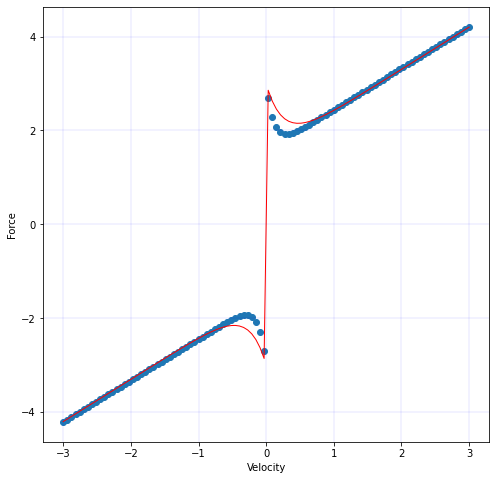

Fc:  1.5579235577268657
vs:  -0.2297687740088341
Beta or sigma 2:  0.8839544687118135
FINAL ERROR:  0.0138016372566773


In [69]:
F_fit = (parameter[0] + (Fs - parameter[0]) * np.exp(-abs(v/parameter[1]))**a)*np.sign(v) +parameter[2]*v
show_model(F_fit, F, v)
print("Fc: ", parameter[0])
print("vs: ", parameter[1])
print("Beta or sigma 2: ", parameter[2])
print("FINAL ERROR: ", final_error)